## Setup

Import the basic libraries.

In [1]:
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import display
import os
%matplotlib inline

Initialize the environment for running the experiment.

In [2]:
os.makedirs('./results/HGaussian_MINEE/', exist_ok=True)

# Paths for loading/storing results.
name = 'results/HGaussian_MINEE_copy' # filename
chkpt_name = name+'.pt'              # checkpoint
fig_name = name+'.pdf'               # output figure

# use GPU if available
if torch.cuda.is_available(): 
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

# initialize random seed
np.random.seed(0)
torch.manual_seed(0);

## Data

Generate data using the gaussian model.

In [3]:
sample_size = 1000   # sample size
rho = 0.9           # model parameter
p = 0.6             # parameter of bernoulli distribution
mu = 1              # mean of Gaussian distribution
rep = 1             # number of repeated runs
d = 1               # number of dimensions for X (and Y)
X = np.zeros((rep,sample_size,d+1))
Y = np.zeros((rep,sample_size,d))
Z = np.zeros((rep,sample_size,d+1))

In [4]:
from scipy.stats import bernoulli
for i in range(rep):
    X_ = bernoulli.rvs(p, size=sample_size)
num_0 = len(X_[X_==0])
num_1 = len(X_[X_==1])

Generate data from bernoulli distribution.

In [5]:
from data.mix_gaussian import MixedGaussian

rho_1 = 0.9
rho_2 = 0.6
d = 1
mg1 = MixedGaussian(sample_size=num_0,rho1=rho_1,rho2=-rho_1)
mg2 = MixedGaussian(sample_size=num_1,rho1=rho_2,rho2=-rho_2)

for i in range(rep):
    for j in range(d):
        data1 = mg1.data
        data2 = mg2.data
        X[i,:num_0,j] = data1[:,0]
        X[i,num_0:,j] = data2[:,0]
        Y[i,:num_0,j] = data1[:,1]
        Y[i,num_0:,j] = data2[:,1]
    X[i,:num_0,d] = X_[X_==0]
    X[i,num_0:,d] = X_[X_==1]

A plot of the first dimension of $Y$ against that of $X$.

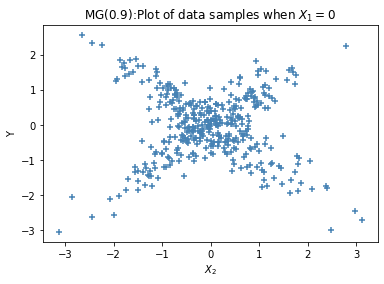

In [6]:
import matplotlib.pyplot as plt
plt.scatter(X[0,:num_0,0],Y[0,:num_0,0],label="data",marker="+",color="steelblue")
plt.xlabel('$X_2$')
plt.ylabel('Y')
plt.title('MG(0.9):Plot of data samples when $X_1=0$')
plt.show()

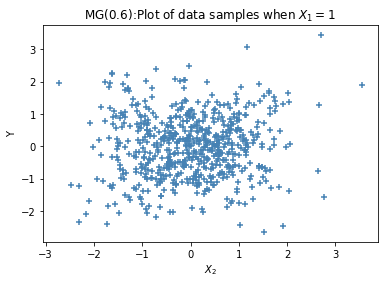

In [7]:
import matplotlib.pyplot as plt
plt.scatter(X[0,num_0:,0],Y[0,num_0:,0],label="data",marker="+",color="steelblue")
plt.xlabel('$X_2$')
plt.ylabel('Y')
plt.title('MG(0.6):Plot of data samples when $X_1=1$')
plt.show()

## Model

Initialize the MINE model.

In [8]:
from model.discrete_minee import MINEE

In [9]:
batch_size = 100       # batch size of data sample
ref_batch_factor = 10  # batch size expansion factor for reference sample
lr = 1e-4              # learning rate

minee_list = []
for i in range(rep):
    minee_list.append(MINEE(torch.Tensor(X[i]),torch.Tensor(Y[i]),
                            batch_size=batch_size,ref_batch_factor=ref_batch_factor,lr=lr))
dXY_list = np.zeros((rep,0))
dX_list = np.zeros((rep,0))
dY_list = np.zeros((rep,0))

Load previous results.

In [10]:
load_available = False # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    dXY_list = checkpoint['dXY_list']
    minee_state_list = checkpoint['minee_state_list']
    for i in range(rep):
        minee_list[i].load_state_dict(minee_state_list[i])
    print('Previous results loaded.')

Continuously train the model. The following can be executed repeatedly and after loading previous results.

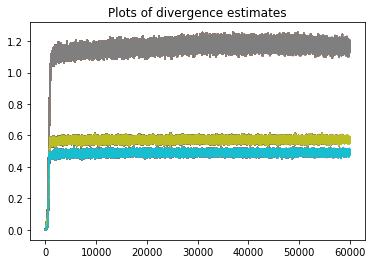

In [11]:
continue_train = True  # set to True to continue to train
num_big_steps = 200     # number of small steps
num_small_steps = 300  # number of big steps
if continue_train:
    for k in range(num_big_steps):
        for j in range(num_small_steps):
            dXY_list = np.append(dXY_list, np.zeros((rep, 1)), axis=1)
            dX_list = np.append(dX_list, np.zeros((rep, 1)), axis=1)
            dY_list = np.append(dY_list, np.zeros((rep, 1)), axis=1)
            for i in range(rep):
                minee_list[i].step()
                dXY_list[i, -1], dX_list[i, -1], dY_list[i, -1] = minee_list[i].forward()
        # To show intermediate works
        for i in range(rep):
            plt.plot(dXY_list[i, :],label='dXY')
            plt.plot(dX_list[i, :],label='dX')
            plt.plot(dY_list[i, :],label='dY')
            plt.title('Plots of divergence estimates')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output()

Save current results.

In [12]:
overwrite = False  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    minee_state_list = [minee_list[i].state_dict() for i in range(rep)]
    torch.save({
        'dXY_list': dXY_list,
        'dX_list': dX_list,
        'dY_list': dY_list,
        'minee_state_list': minee_state_list
    }, chkpt_name)
    print('Current results saved.')

## Analysis

Calculate the ground truth mutual information.

In [13]:
import math
Hy = np.log(np.sqrt(2*math.e*math.pi))
Hxy1 = mg1.ground_truth * d
Hxy2 = mg2.ground_truth * d

mi = (1-p)*Hxy1 + p*Hxy2
print('MI Ground truth is {0} nats.'.format(mi)) 

MI Ground truth is 0.19515707317822545 nats.


Apply moving average to smooth out the mutual information estimate.

In [14]:
mi_ma_rate = 0.01            # rate of moving average
mi_list = (dXY_list-dX_list-dY_list).copy()    # see also the estimate() member function of MINE
for i in range(1,dXY_list.shape[1]):
    mi_list[:,i] = (1-mi_ma_rate) * mi_list[:,i-1] + mi_ma_rate * mi_list[:,i]

Plot the mutual information estimate after different number of iterations. The red dashed line shows the ground truth, and the green dotted line is the number of iterations where 90% of the ground truth is reached.

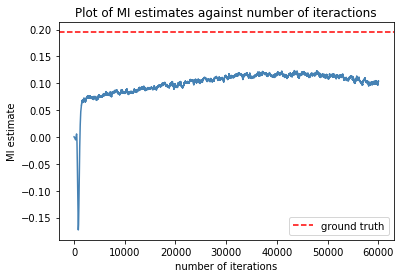

In [15]:
plt.figure()
for i in range(rep):
    plt.plot(mi_list[i,:],color='steelblue')
    for t in range(mi_list[i].shape[0]):
        if (mi_list[0,t]>.9*mi):
            plt.axvline(t,label='90% reached',linestyle=':',color='green')
            break
plt.axhline(mi,label='ground truth',linestyle='--',color='red')
plt.title("Plot of MI estimates against number of iteractions")
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")
plt.legend()
plt.savefig('./results/HGaussian_MINEE/MutualInfo.png')
plt.show()